In [1]:
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
# from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import trange, tqdm
import os

In [12]:
def SI_evaluation(outs, ys):
    with torch.no_grad():
        assert ys.get_device() != -1
        assert outs.get_device() != -1
        ys = ys
        m = outs @ outs.T
        d = torch.diag(m)
        d = d.reshape(-1, 1)
        w = torch.tile(d, (1, outs.shape[0]))
        D = w+w.T - 2*m
        inf = torch.max(D)*100
        I = inf*torch.eye(D.shape[0]).cuda()
        D = D+I
        labs = torch.argmin(D, dim=1)
        labs = labs.detach().cpu().numpy()
        labs = ys[labs]
        return (labs == ys).sum()/len(labs)


def forward_selection(X, y,n = None):
    if n is None:
        n = X.shape[1]
    total_features = list(range(X.shape[1]))
    selected = []
    best_SIs = []
    done = False
    prv_SI = 0
    while not done:
        if len(total_features)==0:
            break
        SI_list = []
        idx_list = []
        for i in tqdm(total_features, leave=False):
            idx = selected.copy()
            if not i in idx:
                idx.append(i)
                features = X[:, idx]
                SI = SI_evaluation(features, y)
                SI_list.append(SI.item())
                idx_list.append(i)

        best_idx = np.argmax(SI_list)
        best_SI = SI_list[best_idx]
        best_feature = idx_list[best_idx]
        print(f"best SI:{best_SI} for {best_feature}")
        # if best_SI <= prv_SI:
        if len(selected)==n:
            print("best features obtaied")
            done = True
        else:
            selected.append(best_feature)
            best_SIs.append(best_SI)
            total_features.remove(best_feature)
            prv_SI = best_SI
    return selected, best_SIs

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
			# nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
			# nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            # nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    
batch_size = 256

transform = transforms.Compose(
    [transforms.ToTensor(), ])
train_set = torchvision.datasets.CIFAR10(root='.', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)
val_set = torchvision.datasets.CIFAR10(root='.', train=False,
                                        download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model = Autoencoder()
model = model.cuda()

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.0000e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.1000e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.2900e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.5610e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.9049e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.3144e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7830e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.3047e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8742e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4868e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.1381e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8243e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5419e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2877e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0589e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8530e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6677e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.5009e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3509e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.2158e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0942e-04.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.8477e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.8629e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.9766e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.1790e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4611e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.8150e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.2335e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.7101e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.2391e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.8152e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.4337e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0903e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.7813e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.5032e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2528e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0276e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.8248e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6423e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4781e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3303e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1973e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0775e-05.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 9.6977e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.7280e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.8552e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0697e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.3627e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.7264e-06.


  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1538e-06.


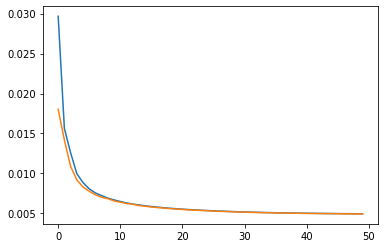

In [10]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9,verbose=True)
train_loss = []
val_loss = []
epochs = 50
outer_loop = trange(epochs)

for epoch in outer_loop:
    r_loss = 0
    for X,y in tqdm(train_loader,leave = False):
        X = X.cuda()
        encoded, decoded = model(X)
        optimizer.zero_grad()
        loss = loss_fn(decoded,X)
        loss.backward()
        optimizer.step()
        r_loss += loss.item()
    train_loss.append(r_loss/len(train_loader))
    with torch.no_grad():
        r_loss = 0
        for X,y in tqdm(val_loader,leave = False):
            X = X.cuda()
            encoded, decoded = model(X)
            loss = loss_fn(decoded,X)
            r_loss += loss.item()
    val_loss.append(r_loss/len(val_loader))
    scheduler.step()
    outer_loop.set_postfix({"train loss":train_loss[-1],
                            "val loss":val_loss[-1]})
plt.plot(train_loss)
plt.plot(val_loss)
# torch.save(model.state_dict(),"model.pt")

In [6]:
with torch.no_grad():
    outs = torch.zeros((10000,384),device="cuda")
    ys = torch.zeros(10000,device="cuda")
    for i,(X,y) in tqdm(enumerate(val_loader),total = len(val_loader)):
        out = model.encoder(X.cuda())
        out = torch.flatten(out,start_dim=1)
        outs[batch_size*i:batch_size*(i+1),:]=out
        ys[batch_size*i:batch_size*(i+1)] = y

  0%|          | 0/40 [00:00<?, ?it/s]

In [11]:
SI_evaluation(outs,ys)

tensor(0.2918, device='cuda:0')

In [17]:
selected, best_SIs = forward_selection(outs,ys,40)

  0%|          | 0/384 [00:00<?, ?it/s]

best SI:0.14270000159740448 for 260


  0%|          | 0/383 [00:00<?, ?it/s]

best SI:0.16009999811649323 for 75


  0%|          | 0/382 [00:00<?, ?it/s]

best SI:0.17889998853206635 for 58


  0%|          | 0/381 [00:00<?, ?it/s]

best SI:0.1955999881029129 for 25


  0%|          | 0/380 [00:00<?, ?it/s]

best SI:0.2084999978542328 for 17


  0%|          | 0/379 [00:00<?, ?it/s]

best SI:0.21570000052452087 for 24


  0%|          | 0/378 [00:00<?, ?it/s]

best SI:0.22659999132156372 for 253


  0%|          | 0/377 [00:00<?, ?it/s]

best SI:0.2345999926328659 for 346


  0%|          | 0/376 [00:00<?, ?it/s]

best SI:0.2378999888896942 for 162


  0%|          | 0/375 [00:00<?, ?it/s]

best SI:0.24650000035762787 for 67


  0%|          | 0/374 [00:00<?, ?it/s]

best SI:0.25380000472068787 for 173


  0%|          | 0/373 [00:00<?, ?it/s]

best SI:0.2624000012874603 for 6


  0%|          | 0/372 [00:00<?, ?it/s]

best SI:0.2687999904155731 for 85


  0%|          | 0/371 [00:00<?, ?it/s]

best SI:0.271699994802475 for 189


  0%|          | 0/370 [00:00<?, ?it/s]

best SI:0.27309998869895935 for 257


  0%|          | 0/369 [00:00<?, ?it/s]

best SI:0.27539998292922974 for 209


  0%|          | 0/368 [00:00<?, ?it/s]

best SI:0.2815999984741211 for 47


  0%|          | 0/367 [00:00<?, ?it/s]

best SI:0.28349998593330383 for 181


  0%|          | 0/366 [00:00<?, ?it/s]

best SI:0.28380000591278076 for 232


  0%|          | 0/365 [00:00<?, ?it/s]

best SI:0.28519999980926514 for 353


  0%|          | 0/364 [00:00<?, ?it/s]

best SI:0.2856999933719635 for 7


  0%|          | 0/363 [00:00<?, ?it/s]

best SI:0.29019999504089355 for 120


  0%|          | 0/362 [00:00<?, ?it/s]

best SI:0.29490000009536743 for 233


  0%|          | 0/361 [00:00<?, ?it/s]

best SI:0.29589998722076416 for 184


  0%|          | 0/360 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 201


  0%|          | 0/359 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 48


  0%|          | 0/358 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 49


  0%|          | 0/357 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 50


  0%|          | 0/356 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 51


  0%|          | 0/355 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 52


  0%|          | 0/354 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 53


  0%|          | 0/353 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 54


  0%|          | 0/352 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 55


  0%|          | 0/351 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 60


  0%|          | 0/350 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 61


  0%|          | 0/349 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 62


  0%|          | 0/348 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 63


  0%|          | 0/347 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 156


  0%|          | 0/346 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 157


  0%|          | 0/345 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 158


  0%|          | 0/344 [00:00<?, ?it/s]

best SI:0.2962999939918518 for 159
best features obtaied


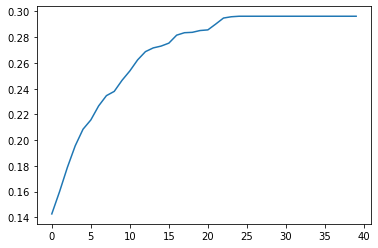

In [18]:
plt.plot(best_SIs)